In [1]:
import numpy as np
import pandas as pd
import pydot
import pygal
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, AdaBoostRegressor
from sklearn.externals.six import StringIO
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from IPython.display import Image, display

In [2]:
# This function creates images of tree models using pydot
def print_tree(estimator, features, class_names=None, filled=True):
    dot_data = StringIO()
    export_graphviz(estimator, out_file=dot_data, feature_names=features, class_names=class_names, filled=filled)
    return pydot.graph_from_dot_data(dot_data.getvalue())

## Training Data

In [3]:
data = pd.read_csv('census_income_train.csv')

In [4]:
y = data.hours_per_week.values
Xcols = np.delete(data.columns.values, 6)
X = data[Xcols]
X.loc[:, 'sex'] = X['sex'].map({' Male': 1, ' Female': 0})
X.loc[:, 'income'] = X['income'].map({' >50K': 1, ' <=50K': 0})

/usr/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


## Testing Data

In [5]:
test_data = pd.read_csv('census_income_test.csv')

In [6]:
y_test = test_data.hours_per_week.values
X_test = test_data[Xcols]
X_test.loc[:, 'sex'] = X_test['sex'].map({' Male': 1, ' Female': 0})
X_test.loc[:, 'income'] = X_test['income'].map({' >50K.': 1, ' <=50K.': 0})

/usr/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


# (a) [Regression Tree]

In [7]:
params = [(5, 2, 2), (10, 2, 2), (10, 4, 4)]
# params = [(3, 2, 2)] * 3

In [8]:
trees = []
mse, mse_test, r2, r2_test = [], [], [], []
for p in params:
    regr = DecisionTreeRegressor(max_depth=p[0], min_samples_split=p[1], min_samples_leaf=p[2])
    regr.fit(X, y)
    graph, = print_tree(regr, features=Xcols)
    trees.append(graph.create_png())
    mse.append(mean_squared_error(y, regr.predict(X)))
    mse_test.append(mean_squared_error(y_test, regr.predict(X_test)))
    r2.append(regr.score(X, y))
    r2_test.append(regr.score(X_test, y_test))

(max_depth, min_samples_split, min_samples_leaf) =  (5, 2, 2)


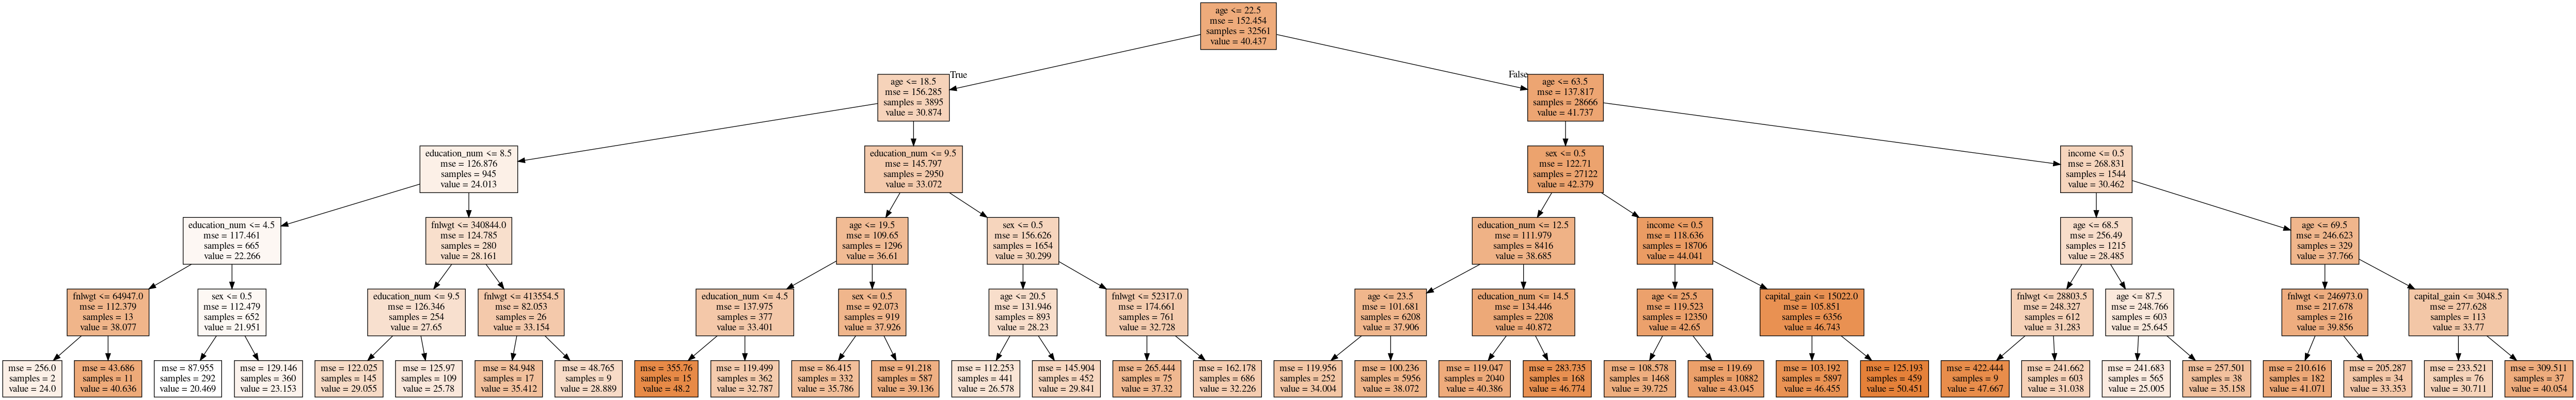

In [9]:
print('(max_depth, min_samples_split, min_samples_leaf) = ', params[0])
Image(trees[0])

(max_depth, min_samples_split, min_samples_leaf) =  (10, 2, 2)


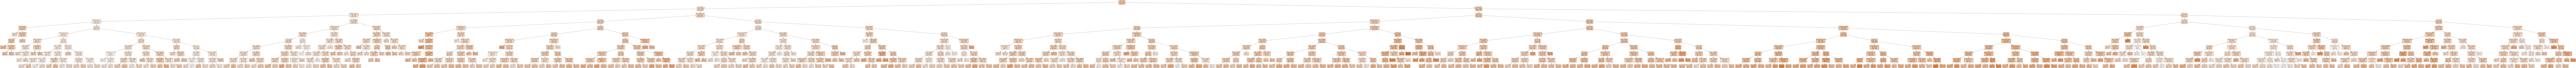

In [10]:
print('(max_depth, min_samples_split, min_samples_leaf) = ', params[1])
Image(trees[1])

(max_depth, min_samples_split, min_samples_leaf) =  (10, 4, 4)


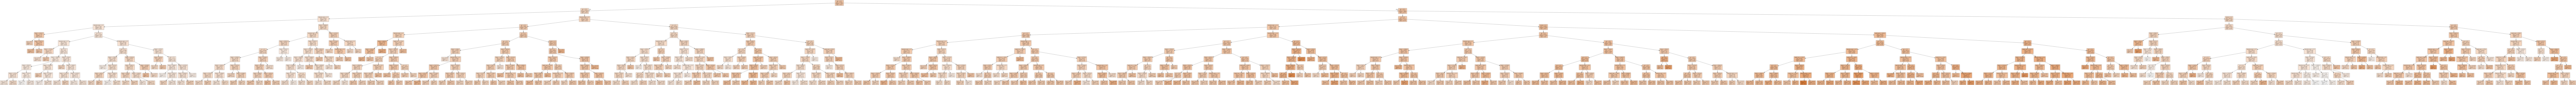

In [11]:
print('(max_depth, min_samples_split, min_samples_leaf) = ', params[2])
Image(trees[2])

In [12]:
pd.DataFrame([mse, mse_test, r2_test],
    columns=[[''] * 3, ['(max_depth, min_samples_split, min_samples_leaf)'] * 3, params],
    index=[['MSE Train', 'MSE Test', 'R2']]
)

\
          (max_depth, min_samples_split, min_samples_leaf)               
                                                 (5, 2, 2)  (10, 2, 2)   
MSE Train                                       119.771998  110.036892   
MSE Test                                        123.632134  128.226494   
R2                                                0.206083    0.176579   

                       
                       
           (10, 4, 4)  
MSE Train  111.454950  
MSE Test   127.175949  
R2           0.183326

In [13]:
depth_cv = []
D = [1, 2, 3, 4, 5, 10, 15, 20 ,25]
for depth in D:
    regr = DecisionTreeRegressor(max_depth=depth)
    regr.fit(X, y)
    err = np.average(cross_val_score(regr, X, y, cv=3, scoring=make_scorer(mean_squared_error)))
    depth_cv.append((depth, err))

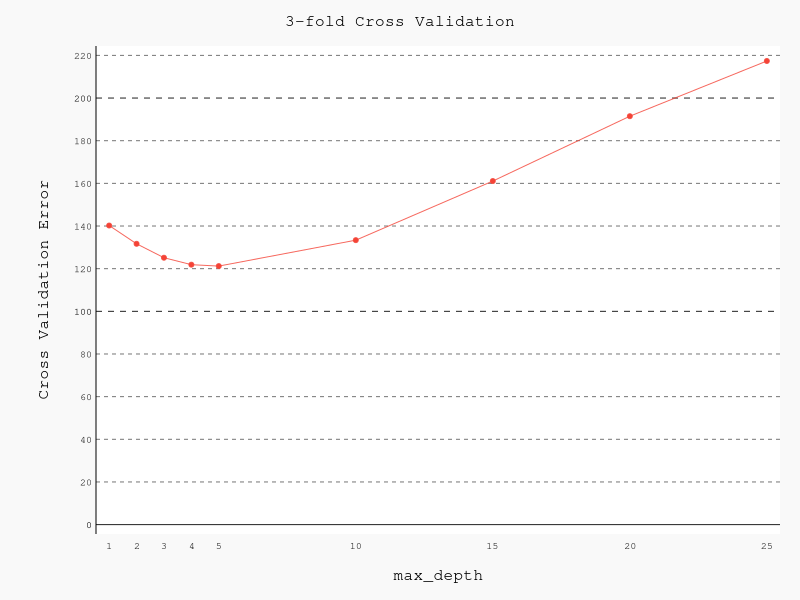

In [14]:
pygal.XY(title = '3-fold Cross Validation',
         range=(0, 220),
         x_title='max_depth',
         y_title='Cross Validation Error',
         x_labels=[x for x,_ in depth_cv]).add(None, depth_cv)

# (b) [Bagging, Random Forests, and Boosting]

In [15]:
B = [20, 40, 60, 80, 100]

In [16]:
mse_bag = []
for b in B:
    regr = BaggingRegressor(n_estimators=b)
    regr.fit(X, y)
    mse = mean_squared_error(y_test, regr.predict(X_test))
    mse_bag.append((b, mse))

In [17]:
mse_rf = []
for b in B:
    regr = RandomForestRegressor(max_features=3, n_estimators=b)
    regr.fit(X, y)
    mse = mean_squared_error(y_test, regr.predict(X_test))
    mse_rf.append((b, mse))

In [18]:
mse_ada = []
for b in B:
    regr = AdaBoostRegressor(DecisionTreeRegressor(max_depth=1), learning_rate=0.01, n_estimators=b)
    regr.fit(X, y)
    mse = mean_squared_error(y_test, regr.predict(X_test))
    mse_ada.append((b, mse))

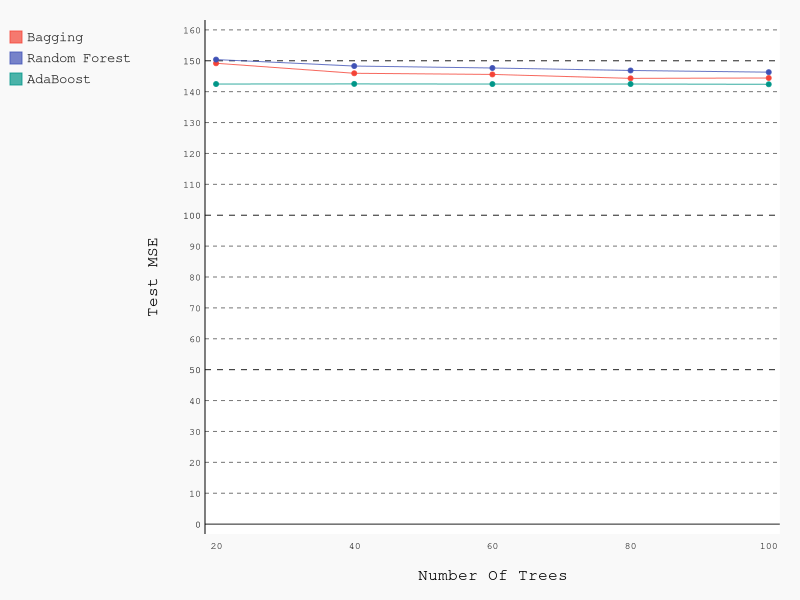

In [19]:
pygal.XY(title = '',
         range=(0, 160),
         x_title='Number Of Trees',
         y_title='Test MSE',
         x_labels=B).add('Bagging', mse_bag).add('Random Forest', mse_rf).add('AdaBoost', mse_ada)